#Trabalho 3
#Sistema de travagem ABS (“Anti-Lock Breaking System”)

Pedro Gomes a91647  
Francisco Teófilo a93741
  


In [5]:
!pip install z3-solver

     |████████████████████████████████| 32.9 MB 1.6 MB/s 


In [6]:
from z3 import *
import sys, os
import matplotlib.pyplot as plt

Começamos por criar o autómato que ilustra o model **ABS** e o seu funcionamento.  
Escolhemos como **valores das variáveis:**   
Velocidade Inicial $V$ = 28 m/s (100 km/h)  
Tempo $t$ = 0   
Timers do FREE e do STOPPED $t1, t2$  
Velocidade das Rodas $r$ = 0  
**E como constantes**:   
Contacto $c$ = 0.5 no modo FREE e $c$ = 4 no modo STOPPING   
Intervalo entre leituras $x$ = 0.3

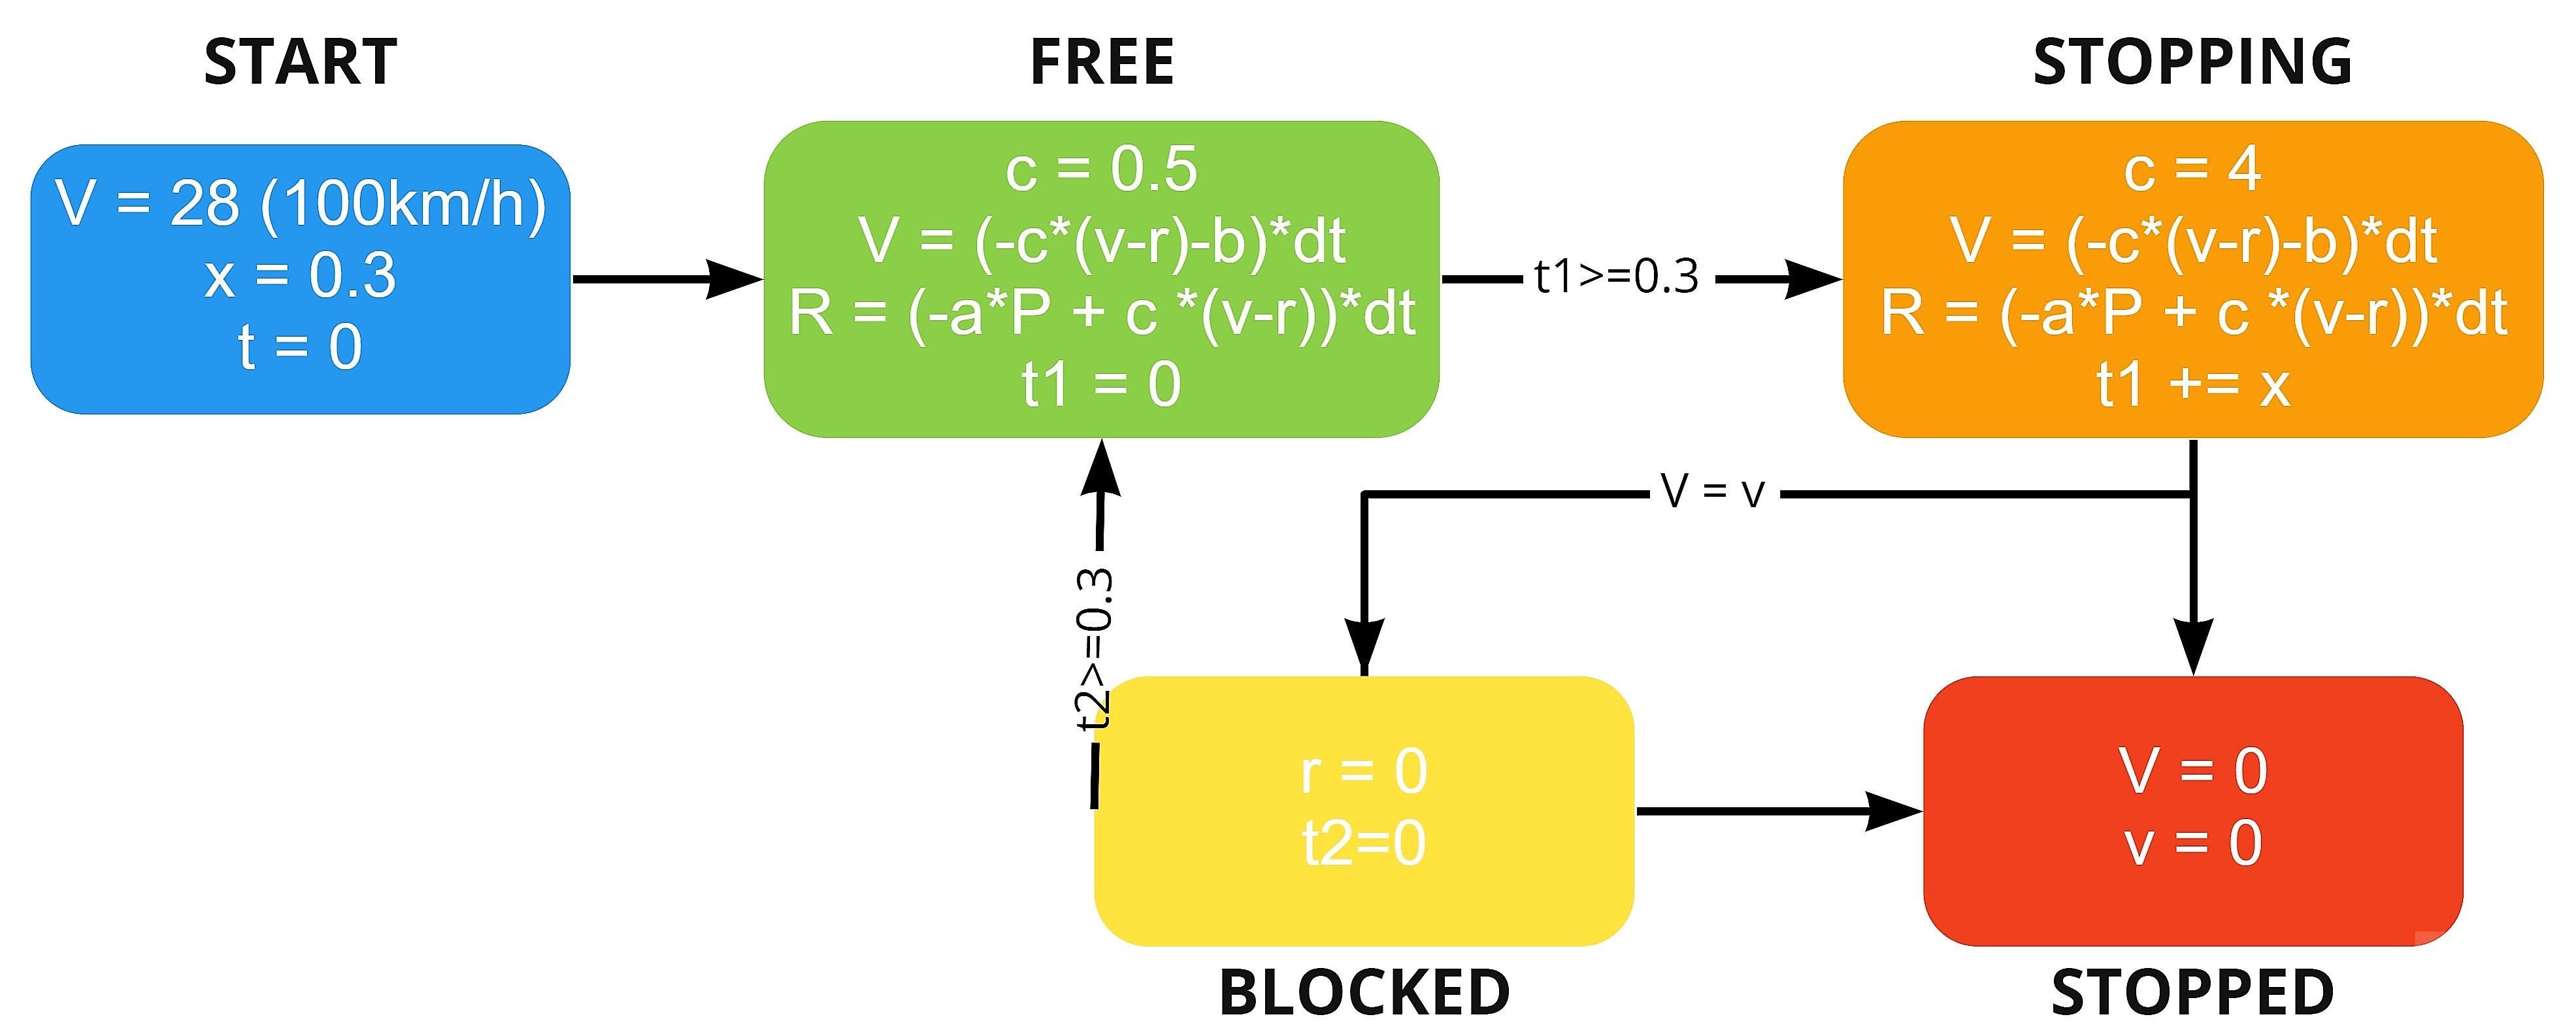

Agora implementamos uma simulação do comportamento das velocidades do corpo e das rodas com a atuação do sistema de travagem ABS.
Para $input$ assumimos um corpo de massa 1000kg, a uma velocidade de 100 km/h (28 m/s), atrito $a$ = 0.01 e tempo $t$ = 10s e dt = 0.1.

Velocidade do corpo: $v = v + (-c \cdot (v-r)-b) \cdot dt$  
Velocidade das rodas: $r = r + (-a \cdot P + c \cdot (v-r)) \cdot dt$  

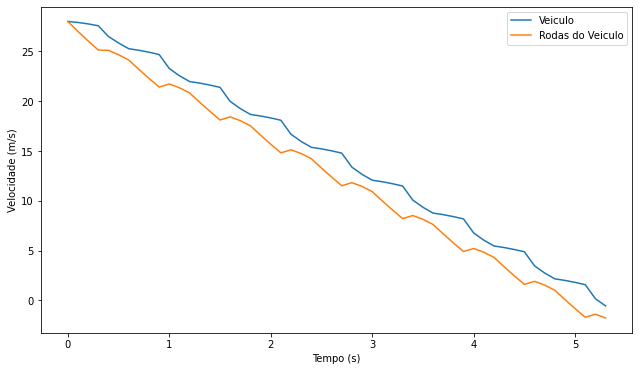

In [7]:
def constantes_plot(a, b, c, P, time, v_inicial):
    v = v_inicial
    r = v_inicial
    t = 0
    V = [v]
    R = [r]
    T = [t]
    dt = 0.1
    x = 0.3
    timer = 0
    m = "free"
    while(t<time and (v>0 or r>0)):
        if timer > x and m== "free":
            c = 4
            m = "stopping"
            timer = 0
        elif timer > x and m=="stopping":
            c = 0.5
            m = "free"
            timer = 0
        timer+= dt 
        v,r  = v +(-c*(v-r)-b)*dt, r + (-a*P + c *(v-r))*dt
        t += dt
        V.append(v)
        R.append(r)
        T.append(t)
    
    fig = plt.figure(figsize=(10.6, 6))
    plt.plot(T,V,T,R)
    plt.legend(['Veiculo', 'Rodas do Veiculo'], loc=1)
    plt.ylabel('Velocidade (m/s)')
    plt.xlabel('Tempo (s)')

constantes_plot(0.01, 1, 0.5, 1000, 10, 28)

Observamos, na análise do gráfico obtido, que a velocidade do corpo é sempre superior à velocidade das rodas, até ambas serem iguais a zero.
Neste caso para um corpo de 1000kg a 100km/h demora pouco mais de 5 segundos para o corpo ser imobilizado. 

Agora, para a verificação do autómato híbrido, usamos um tipo enumerado para implementar os modos.



In [8]:
Modes, (Start, Free, Stopping, Blocked, Stopped) = EnumSort('Modes',['Start', 'Free', 'Stopping', 'Blocked', 'Stopped'])
Events, (start, goStopping, goFree, goBlocked, goStopped) =  \
    EnumSort('Events',['start', 'goStopping', 'goFree', 'goBlocked', 'goStopped'])

Declaramos as variáveis do FOTS correspondente ao sistema de travagem ABS (“Anti-Lock Breaking System”) da seguinte forma.

In [9]:
N = 10
Fd = 0.1
Fe = 1
VP = 2
a = 0.01
b = 1
c = 0.5
v = RealVector('v', N+1) #velocidade do veiculo
r = RealVector('r', N+1) #velocidade das rodas
temp = RealVector('t', N+1) 
modes = AstVector() ; modes.resize(N+1)
events = AstVector() ; events.resize(N+1)
consts = [a,b,c]

for k in range(N+1):
    modes[k] = Const('md_'+str(k), Modes)

for k in range(N+1):
    events[k] = Const('ev_'+str(k), Events)

def S(k):
    return (v[k],r[k],temp[k],modes[k])

def E(k):
    return events[k]

**Codificação dos estados do FOTS.**


In [10]:
def init(S):
    (V,R,T,M) = S 
    return And(R <= V, V>0, R>0, M == Start)

In [11]:
def inv(S):
    (V,R,T,M) = S 
    return And(Implies( M == Start    , T == 0             ),
               Implies( M == Free     , V >= R, R>0,       ),
               Implies( M == Stopping , And(R >= 0, V >= R)),
               Implies( M == Blocked  , And(R == 0, V >= 0)),
               Implies( M == Stopped  , And(V == R, R == 0)))

In [12]:
def timed(S,S_,E):
    (V,R,T,M) = S ; (V_,R_,T_,M_) = S_ 
    return And( M == M_,
                T_ > T,
                Implies( M == Start    , And(V == V_, R == R_)                                        ),
                Implies( M == Free     , And((V_ - V) + Fd*(T_ - T) == 0, (R_ - R) - Fe*(T_ - T) == 0)),
                Implies( M == Stopping , And((V_ - V) + Fd*(T_ - T) == 0, (R_ - R) + Fe*(T_ - T) == 0)),
                Implies( M == Blocked  , And((V_ - V) + (T_ - T) == 0, R == R_, R == 0)               ),
                Implies( M == Stopped  , And(V == V_, R == R_)                                        ))

In [13]:
def untimed(S,S_,E):
    (V,R,T,M) = S ; (V_,R_,T_,M_) = S_ 
    return And( V == V_,
                R == R_,
                T == T_,
                Implies( E == start      , And( M == Start    , M_ == Free     , R <= V, R>0)),
                Implies( E == goStopping , And( M == Free     , M_ == Stopping , V - R == 0) ),
                Implies( E == goFree     , And( M == Blocked  , M_ == Free     , V - R >= VP)),
                Implies( E == goBlocked  , And( M == Stopping , M_ == Blocked  , R == 0)     ),
                Implies( E == goStopped  , And( M == Blocked  , M_ == Stopped  , V == 0)     ),
                Implies( E == goStopped  , And( M == Stopping , M_ == Stopped  , V == 0)     ))

In [14]:
def blocked(S,S_,E): 
    (V,R,T,M) = S ; (V_,R_,T_,M_) = S_ 
    return  And(V_ == V, R_ == R, T_ == T, M_ == M)

In [15]:
def trans(S,S_,E): 
    return Or(blocked(S,S_,E), timed(S,S_,E), untimed(S,S_,E))

In [16]:
s = Solver()

s.add(init(S(0)))

for k in range(N-1):
    s.add(inv(S(k)))
    s.add(trans(S(k),S(k+1),E(k+1)))  

s.add(inv(S(N)))

print(s.check())

sat


Estado: Start
v = 10
r = 10
t = 0
--
Transicao: start
-->
Estado: Free
v = 10
r = 10
t = 0
--
Transicao: goStopping
-->
Estado: Stopping
v = 10
r = 10
t = 0
--
Transicao: start
-->
Estado: Stopping
v = 19/2
r = 5
t = 5
--
Transicao: goStopped
-->
Estado: Stopping
v = 19/2
r = 5
t = 5
--
Transicao: start
-->
Estado: Stopping
v = 9
r = 0
t = 10
--
Transicao: goBlocked
-->
Estado: Blocked
v = 9
r = 0
t = 10
--
Transicao: start
-->
Estado: Blocked
v = 17/2
r = 0
t = 21/2
--
Transicao: start
-->
Estado: Blocked
v = 0
r = 0
t = 19
--
Transicao: start
-->
Estado: Blocked
v = 0
r = 0
t = 19
--
Transicao: None
-->


Text(0.5, 0, 'Tempo (s)')

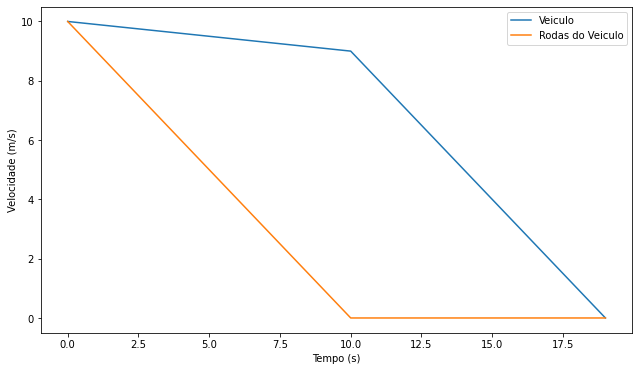

In [ ]:
def gera(S, init, inv, trans, k):
    s = Solver()
    frac2float = lambda x : float(x.numerator_as_long())/float(x.denominator_as_long())

    s.add(init(S(0)))

    for i in range(k-1):
        s.add(inv(S(i)))
        s.add(trans(S(i),S(i+1),E(i)))  

    s.add(inv(S(k)))

    if s.check() == sat:
        m = s.model()
        for i in range(k):
            print("Estado:", m[modes[i]])
            print('v =',m[v[i]])
            print('r =',m[r[i]])
            print('t =',m[temp[i]])
            print('--')
            print('Transicao:',m[events[i]])
            print('-->')
        
        T  = [frac2float(m[temp[i]]) for i in range(k)]
        VV = [frac2float(m[v[i]]) for i in range(k)]
        VR = [frac2float(m[r[i]]) for i in range(k)]
        return T, VV, VR
    else:
        print("Não tem solução.")
                   
T, VV, VR = gera(S, init, inv, trans, 10)

fig = plt.figure(figsize=(10.6, 6))
plt.plot(T, VV, T, VR)
plt.legend(['Veiculo', 'Rodas do Veiculo'], loc=1)
plt.ylabel('Velocidade (m/s)')
plt.xlabel('Tempo (s)')

# Verificação de propriedades

1.   ”o veículo imobiliza-se completamente em menos de $t$ segundos”


In [17]:
def P1(S,S_):
    (V,R,T,M) = S; (V_,R_,T_,M_) = S_ 

    return And(Implies( M == Stopped, And(V_ == 0, T_ < T)))  

s = Solver()

s.add(init(S(0)))

for k in range(N-1):
    s.add(P1(S(k),S(k+1)))
    s.add(trans(S(k),S(k+1),E(k+1)))  

s.add(P1(S(N),S(N)))

print(s.check())

sat


2.   “a velocidade $V$ diminui sempre com o tempo”.

In [18]:
def P2(S,S_):
    (V,R,T,M) = S; (V_,R_,T_,M_) = S_

    return And(Implies( M == Free     , And(V_ < V, T_>T)),
               Implies( M == Stopping , And(V_ < V, T_>T)),
               Implies( M == Blocked  , And(V_ < V, T_>T)),
               Implies( M == Stopped  , And(V_ < V, T_>T))) 

s = Solver()

s.add(init(S(0)))

for k in range(N-1):
    s.add(P2(S(k),S(k+1)))
    s.add(trans(S(k),S(k+1),E(k+1)))  

s.add(P2(S(N),S(N)))

print(s.check())

sat


Verificamos assim que as propriedade $P1$ e $P2$ são satisfeitas.